# Project 1: Analyzing Spectroscopic data from OMM

In [41]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
plt.rcParams['figure.figsize'] = (14, 5)

## Part 1: Exploration

We can define a plotting function for our FITS files for repeated plotting down the line

In [42]:
#NOTE: Turn basic fits astropy file manipulations into a class
# class AstropyFits:
#     def __init__(self):
#         self.fits_file = fits_file
#
#     def convert_fits_to_data(self, ):


In [43]:
def plot_fits(data, title, norm = None):
    #plot the data...
    fig, ax = plt.subplots()
    ax.imshow(data, cmap='viridis', origin='lower', norm=norm, aspect='auto')
    ax.set_xlabel('x pixels')
    ax.set_ylabel('y pixels')
    ax.set_title(title)

def fits_to_data(file_name):
    source_file = fits.open(file_name)
    source_data = source_file[0].data
    return source_data, source_file


Let's produce some rough visualizations of the source file, a calibration lamp, and dark frame.

In [44]:
parent = './fit_files/'
source_fits = parent + 'source.fits'
cal_lamp_fits = parent + 'calibration.fits'
bias_frame_fits = parent + 'bias0008.fits'
dark_frame_fits = parent + 'dark0001.fits'

In [45]:
s_data, s_file = fits_to_data(source_fits)
cal_lamp_data, cal_lamp_file = fits_to_data(cal_lamp_fits)
bias_frame_data, bias_frame_file = fits_to_data(bias_frame_fits)
dark_frame_data, dark_frame_file = fits_to_data(dark_frame_fits)

Viewing the header of the source file, we can see the source is Orion and look at other things like photometric results and observing details.

In [50]:
source_header = s_file[0].header
print(repr(source_header))

SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'orion   '           / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =              1800.00  / Temps d'exposition (sec)                      
DARKTIME=              1800.00  / Temps total ecoule (sec)                      
IMAGETYP= 'object  '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:21:

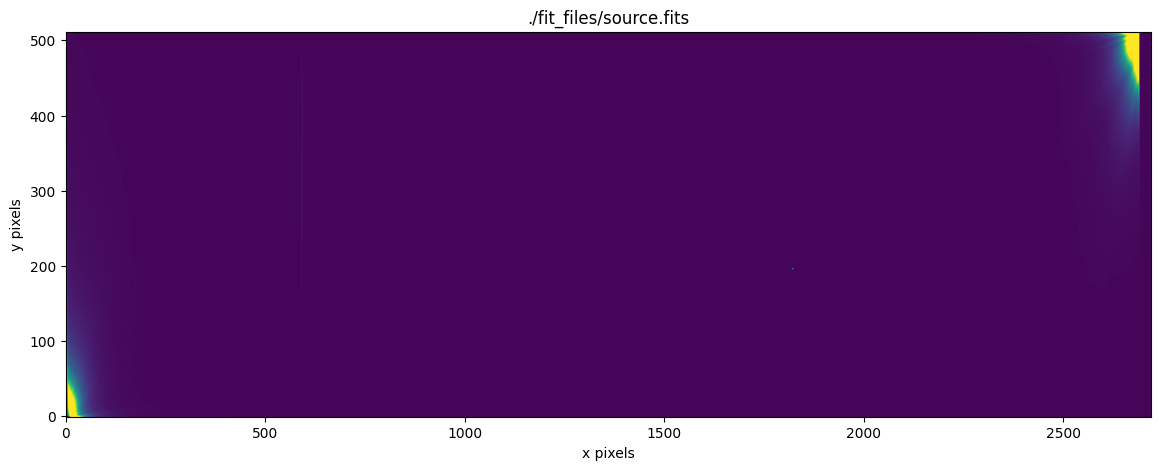

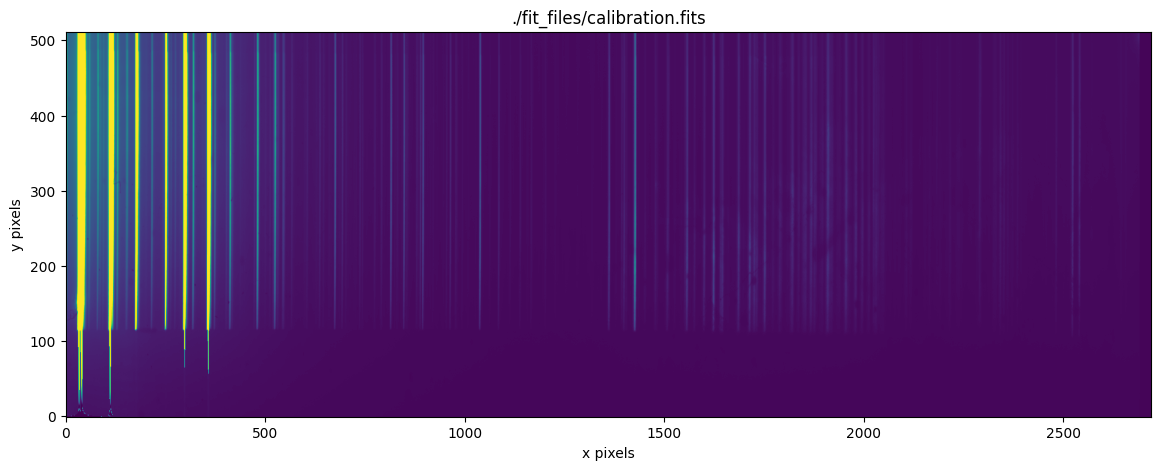

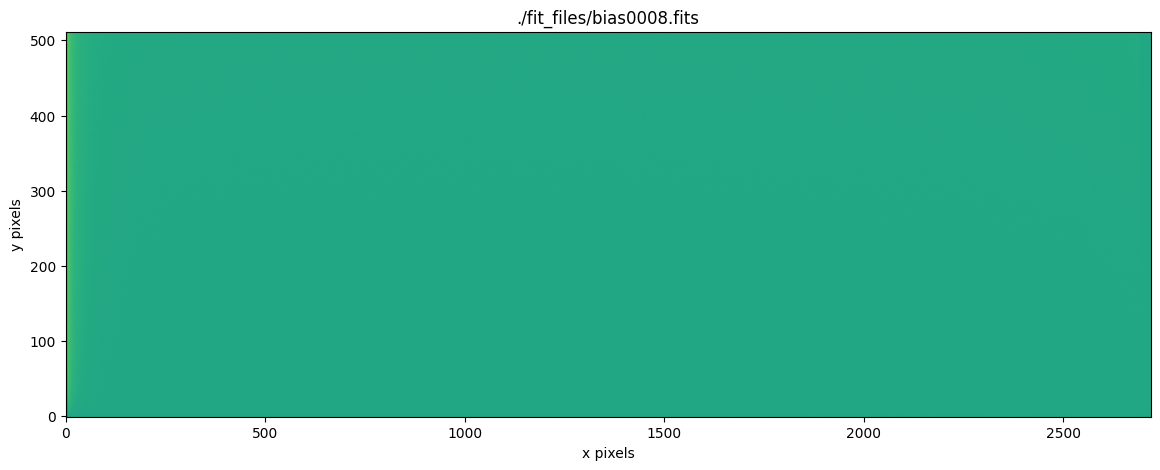

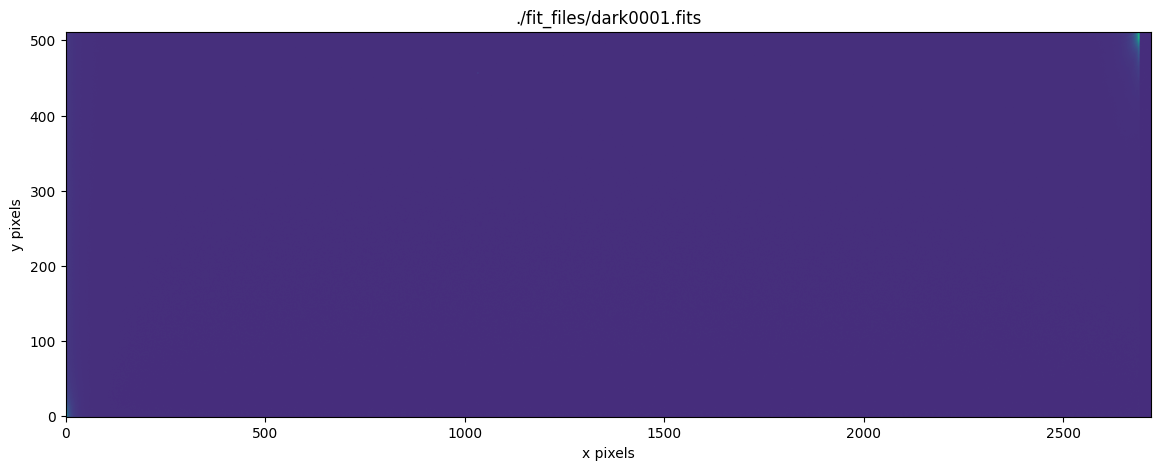

In [51]:
#Now let's plot the different images:
plot_fits(s_data, title=source_fits, norm=None)
plot_fits(cal_lamp_data, title=cal_lamp_fits, norm=None)
plot_fits(bias_frame_data, title=bias_frame_fits, norm=None)
plot_fits(dark_frame_data, title=dark_frame_fits, norm=None)


Let's take a look at what the 'data' files look like so we have an idea of what needs to be done algorithmically when trying to compute the PS.

In [55]:
print(type(s_data))
print(s_data)

<class 'numpy.ndarray'>
[[863 859   0 ... 848 852 856]
 [854 856   0 ... 856 847 844]
 [843 842   0 ... 838 847 841]
 ...
 [850 849   0 ... 846 849 841]
 [849 848   0 ... 849 839 850]
 [850 851   0 ... 855 841 847]]


Ok, so the data is just a 2D matrix and morever a Numpy array so we can perform all the basic math operations on it.

Text(0, 0.5, 'photon counts')

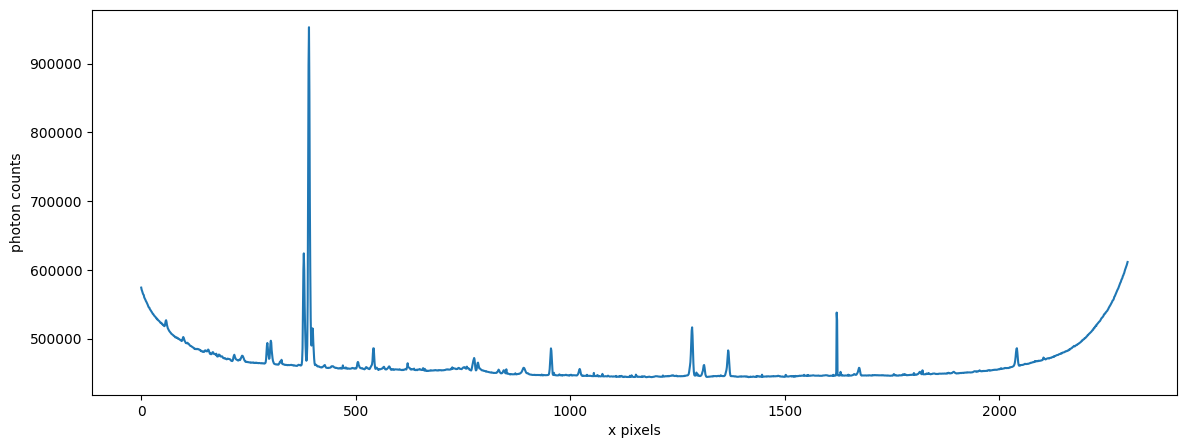

In [71]:
source_spectrum = np.sum(s_data[:, 200:2500], axis = 0)
plt.plot(source_spectrum)
plt.xlabel("x pixels")
plt.ylabel("photon counts")